<a href="https://colab.research.google.com/github/aberah29/Breast-Cancer-Classification-Using-Python-/blob/main/Breast_Cancer_Classification_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing The Libraries

In [2]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.metrics import *

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

AUTOTUNE = tf.data.experimental.AUTOTUNE
folds_dataframe = pd.read_csv('/content/drive/MyDrive/Dataset/Folds.csv')
images_directory = '/content/drive/MyDrive/Dataset/BreaKHis_v1/'
tumor_types = ['benign', 'malignant']


# Let's Check for the Duplicate Values in the CSV File

In [3]:
# Check for duplicate filenames
duplicate_filename_count = folds_dataframe['filename'].duplicated().sum()
print(f'Number of duplicate filenames: {duplicate_filename_count}')

Number of duplicate filenames: 31636


# Removing the Duplicate Values

In [4]:
# Remove duplicate rows based on the 'filename' column to retain only unique entries
folds_dataframe = folds_dataframe.drop_duplicates(subset='filename', keep='first')
# Print the updated shape of the DataFrame
print(f'Updated shape of the DataFrame: {folds_dataframe.shape}')

Updated shape of the DataFrame: (7909, 4)


In [5]:
# Rename the 'filename' column to 'path'
folds_dataframe = folds_dataframe.rename(columns={'filename': 'path'})

# Extract and assign labels from the path
folds_dataframe['label'] = folds_dataframe['path'].apply(lambda x: x.split('/')[3])

# Convert labels to integer indices
folds_dataframe['label_int'] = folds_dataframe['label'].apply(lambda x: tumor_types.index(x))

# Extract and assign file names from the path
folds_dataframe['file_name'] = folds_dataframe['path'].apply(lambda x: x.split('/')[-1])

# Update the 'path' column to include the full image folder path
folds_dataframe['path'] = folds_dataframe['path'].apply(lambda x: images_directory + x)

# Display the first three rows of the DataFrame
folds_dataframe.head(3)


,fold,mag,grp,path,label,label_int,file_name
0,1,100,train,/content/drive/MyDrive/Dataset/BreaKHis_v1/Bre...,benign,0,SOB_B_A-14-22549AB-100-001.png
1,1,100,train,/content/drive/MyDrive/Dataset/BreaKHis_v1/Bre...,benign,0,SOB_B_A-14-22549AB-100-002.png
2,1,100,train,/content/drive/MyDrive/Dataset/BreaKHis_v1/Bre...,benign,0,SOB_B_A-14-22549AB-100-003.png


Count of Benign    :  2480
Count of Malignant :  5429


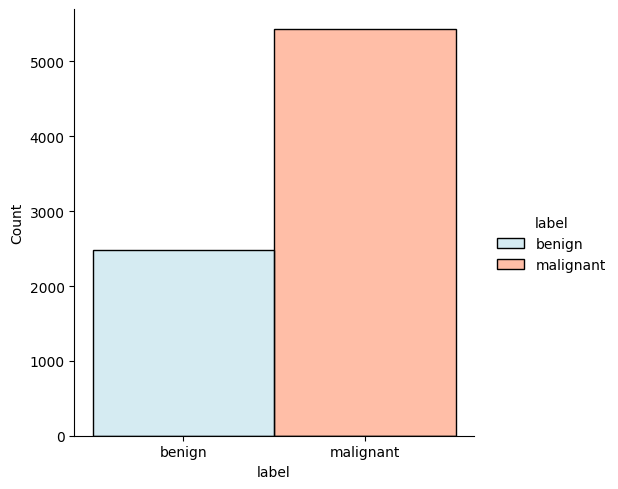

In [6]:
# Defining colors for tumor types
ax = sns.displot(
    data=folds_dataframe,
    x='label',
    hue='label',
    palette={'benign': 'lightblue', 'malignant': 'coral'}
)

# Displaying the count of each label
print('Count of Benign    : ', folds_dataframe[folds_dataframe['label'] == 'benign']['label'].count())
print('Count of Malignant : ', folds_dataframe[folds_dataframe['label'] == 'malignant']['label'].count())


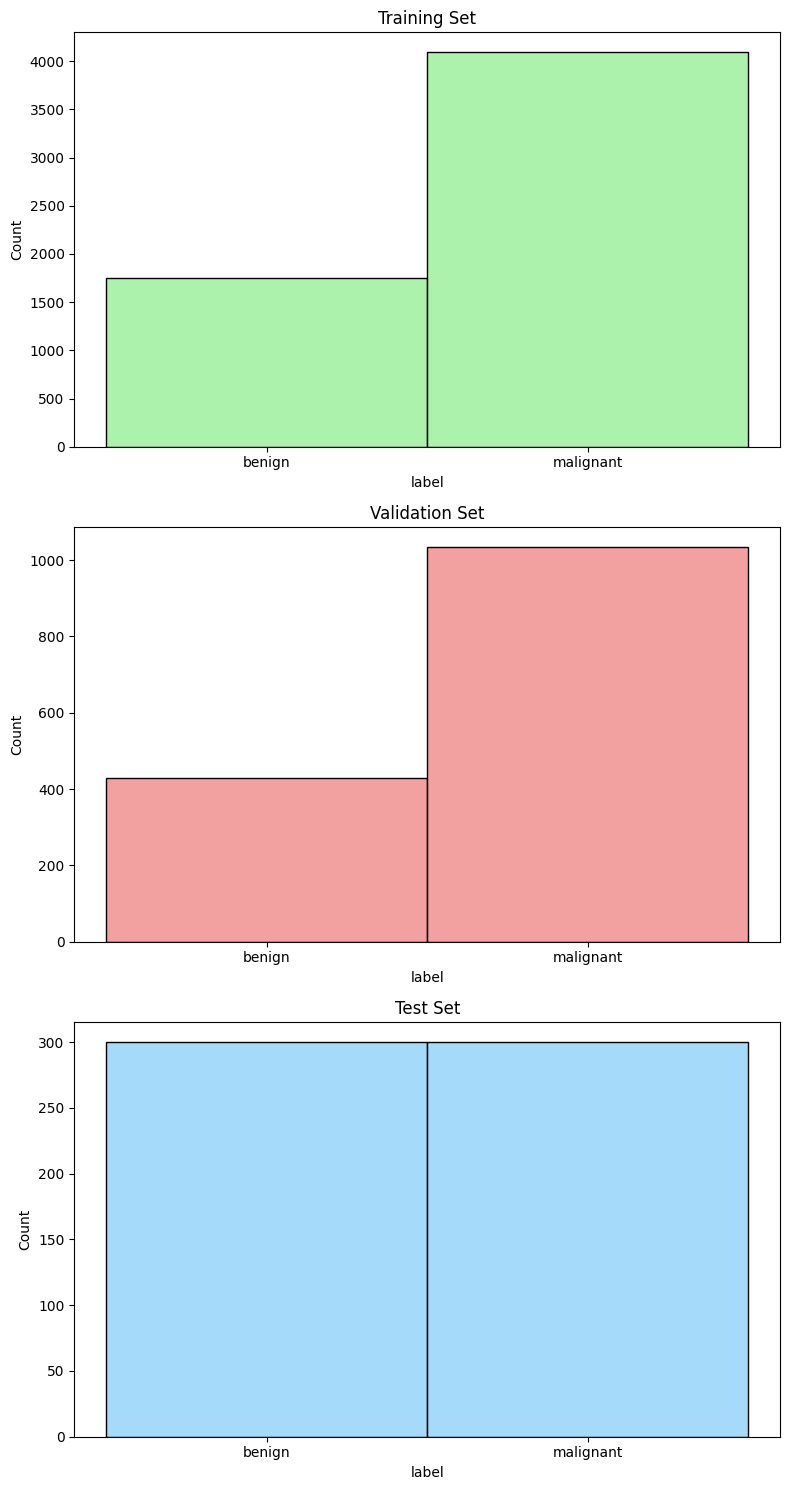

Training set
label
malignant    4095
benign       1752
Name: count, dtype: int64

Validation set
label
malignant    1034
benign        428
Name: count, dtype: int64

Test set
label
benign       300
malignant    300
Name: count, dtype: int64


In [7]:
# Remove 600 samples from the dataset for testing
test_dataset = folds_dataframe.groupby('label').sample(n=300)
train_dataset = folds_dataframe.drop(test_dataset.index).reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

# Split training and validation sets
validation_dataset = train_dataset.sample(frac=0.2)
train_dataset = train_dataset.drop(validation_dataset.index).reset_index(drop=True)
validation_dataset = validation_dataset.reset_index(drop=True)

# Assign set labels and combine data
test_dataset['set'] = 'test'
train_dataset['set'] = 'train'
validation_dataset['set'] = 'valid'
combined_dataset = pd.concat([train_dataset, validation_dataset, test_dataset])

# Set up the figure with a column of three subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 15))

# Plot each distribution in a different color and assign to specific axes
sns.histplot(data=train_dataset, x='label', color='lightgreen', ax=axes[0])
axes[0].set_title('Training Set')

sns.histplot(data=validation_dataset, x='label', color='lightcoral', ax=axes[1])
axes[1].set_title('Validation Set')

sns.histplot(data=test_dataset, x='label', color='lightskyblue', ax=axes[2])
axes[2].set_title('Test Set')

# Show the plots in a vertical layout
plt.tight_layout()
plt.show()

# Print counts for each set
print('Training set')
print(train_dataset['label'].value_counts())

print('\nValidation set')
print(validation_dataset['label'].value_counts())

print('\nTest set')
print(test_dataset['label'].value_counts())


# UpSampling Dataset to Remove Class Imbalance

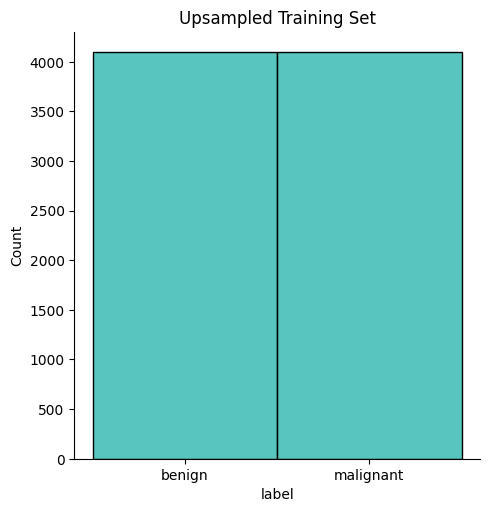

label
benign       4095
malignant    4095
Name: count, dtype: int64


In [8]:
# Upsample the training dataset
max_count = np.max(train_dataset['label'].value_counts())
train_dataset = train_dataset.groupby('label').sample(n=max_count, replace=True).reset_index(drop=True)

# Plot distribution after upsampling
ax = sns.displot(data=train_dataset, x='label', color='lightseagreen')
ax.set(title='Upsampled Training Set')
plt.show()

# Display counts to verify upsampling
print(train_dataset['label'].value_counts())


In [9]:
# Convert 'label_int' to string type for categorical class mode
train_dataset['label_int'] = train_dataset['label_int'].astype(str)
validation_dataset['label_int'] = validation_dataset['label_int'].astype(str)

# Data augmentation setup with updated values
train_image_generator = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use a simpler validation generator with rescaling only
validation_image_generator = ImageDataGenerator(rescale=1./255)

# Training data generator setup
train_data_generator = train_image_generator.flow_from_dataframe(
    dataframe=train_dataset,
    directory='',
    x_col='path',
    y_col='label_int',
    target_size=(150, 150),
    batch_size=64,
    class_mode='sparse'
)

# Validation data generator setup
validation_data_generator = validation_image_generator.flow_from_dataframe(
    dataframe=validation_dataset,
    directory='',
    x_col='path',
    y_col='label_int',
    target_size=(150, 150),
    batch_size=64,
    class_mode='sparse'
)


Found 8190 validated image filenames belonging to 2 classes.
Found 1462 validated image filenames belonging to 2 classes.


# Defining the Model

In [10]:
model = models.Sequential()

# First convolutional block
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Second convolutional block
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# Third convolutional block
model.add(layers.Conv2D(128, (5, 5), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.35))

# Fourth convolutional block
model.add(layers.Conv2D(256, (5, 5), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

# Flatten and fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))  # Adjust output layer for 2 classes


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 146, 146, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 146, 146, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 142, 142, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 71, 71, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 71, 71, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 67, 67, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 67, 67, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 63, 63, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 27, 27, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 27, 27, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 23, 23, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 7, 7, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 7, 7, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 3, 3, 256)           │       1,638,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,356,962 (12.81 MB)

 Trainable params: 3,355,234 (12.80 MB)

 Non-trainable params: 1,728 (6.75 KB)

# Model Training

In [12]:
# Train the model
history = model.fit(
    train_data_generator,        # Training data generator
    epochs=20,                   # Number of epochs (adjust as needed)
    validation_data=validation_data_generator,  # Validation data generator
    verbose=1                    # Verbosity mode for training progress output
)

# Save the trained model if needed
model.save('custom_cnn_model_breast_cancer.h5')


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


128/128 ━━━━━━━━━━━━━━━━━━━━ 4602s 33s/step - accuracy: 0.6537 - loss: 0.8603 - val_accuracy: 0.7073 - val_loss: 1.6735
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.7698 - loss: 0.4910 - val_accuracy: 0.7018 - val_loss: 0.9811
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.7951 - loss: 0.4223 - val_accuracy: 0.7141 - val_loss: 1.0476
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.8284 - loss: 0.3888 - val_accuracy: 0.7093 - val_loss: 0.6347
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.8489 - loss: 0.3410 - val_accuracy: 0.7025 - val_loss: 0.7003
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.8556 - loss: 0.3354 - val_accuracy: 0.7059 - val_loss: 0.6457
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.8636 - loss: 0.3157 - val_accuracy: 0.5616 - val_loss: 0.7576
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.8667 - loss: 0.3097 - val_accuracy: 0.7